In [1]:
import pandas as pd
df = pd.read_csv('tw_train.csv')
df


,交易日,交易別,股票代號,股票名稱,股數,單價,進帳/出帳,Unnamed: 7,XIRR,總成本(賣-買),總價值(現值+配息),總獲利(%),總配息
0,2021/01/11,買,0050,NaN,130.0,131.90,-17147,NaN,23.39%,-448141.0,719607.0,60.576024,28842.0
1,2021/01/15,買,2330,台積,20.0,612.00,-12240,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/01/20,買,2376,技嘉,40.0,79.50,-3180,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/01/25,買,2330,台積,5.0,644.00,-3220,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/01/29,買,2330,NaN,5.0,603.00,-3015,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2025/02/04,買,00631L,NaN,360.0,232.40,-83664,NaN,NaN,NaN,NaN,NaN,NaN
146,2025/04/07,買,006208,NaN,50.0,93.35,-4667,NaN,NaN,NaN,NaN,NaN,NaN
147,2025/04/07,買,00631L,NaN,20.0,160.25,-3209,NaN,NaN,NaN,NaN,NaN,NaN
148,2025/04/07,買,00631L,NaN,20.0,160.25,-3209,NaN,NaN,NaN,NaN,NaN,NaN


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed



=== 總結報告 ===
累積買入金額：759,505.00 元
淨現金流：-425,324.00 元
實際淨投入資金：425,324.00 元
最終組合市值（現有持股）：591,568.74 元
總獲利：166,244.74 元
總獲利百分比：39.09%
XIRR: 13.16%
最終累積績效: 39.09%
每日 IRR: 0.0292%
年化 IRR: 7.64%
夏普值: 0.4709
最大回撤: -36.68%

=== 投資組合股票明細 ===
+----------+------------+----------------+---------+---------------+--------+----------+------------+
| Symbol   | Name       |   Quantity_now |   Price |   Price_Total |   Cost |     Gain |    Gain(%) |
|----------+------------+----------------+---------+---------------+--------+----------+------------|
| 0050     | 0050       |              0 |  nan    |           nan |  21187 |    349   |   1.64724  |
| 2330     | 台積       |              0 |  nan    |           nan |  39876 |   3004   |   7.53335  |
| 2376     | 技嘉       |            100 |  244.5  |         24450 |   8809 |  15641   | 177.557    |
| 006208   | 006208     |           3801 |  102.45 |        389412 | 276457 | 112955   |  40.8582   |
| 2884     | 玉山金     |              0 |  nan    |        

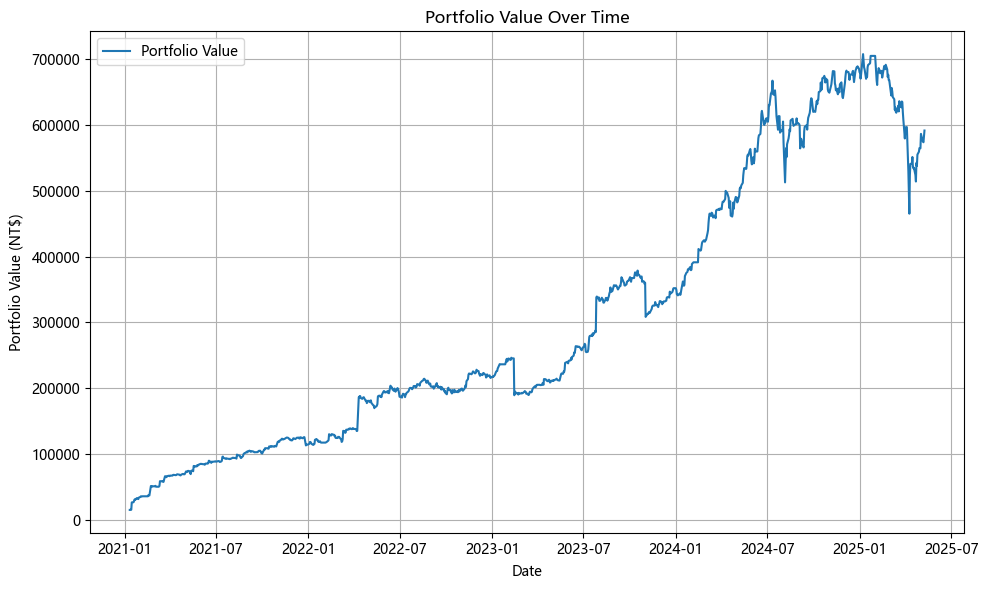

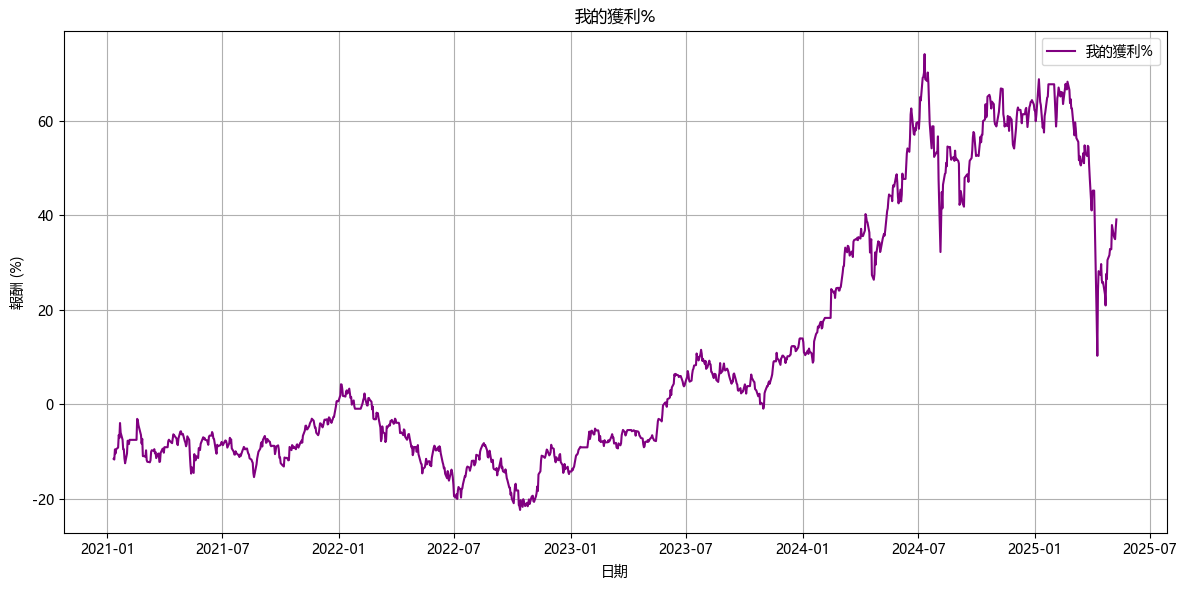

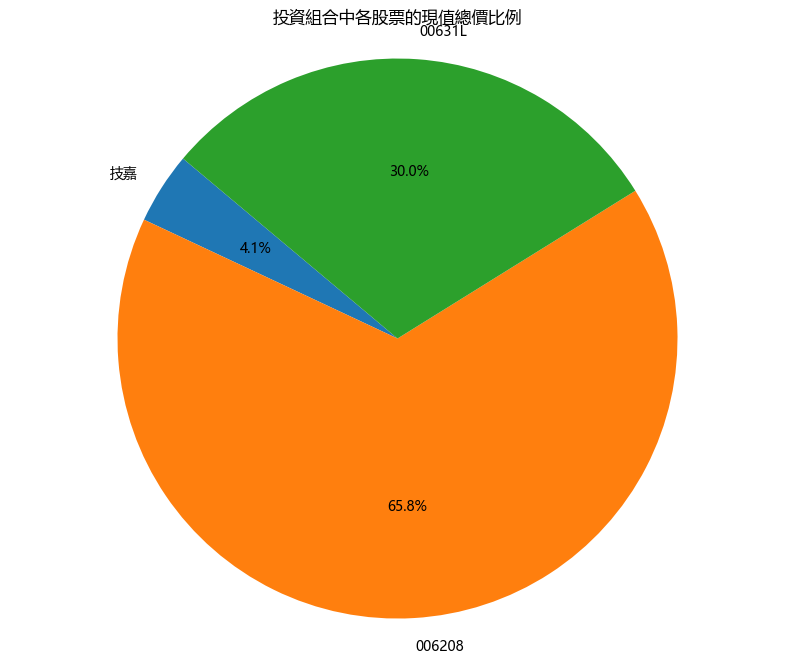

2023/2/10 到 2023/2/15 的市值:
2023-02-10    245303.546211
2023-02-13    245381.954605
2023-02-14    189410.041023
2023-02-15    192768.622902
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    245303.546211
2023-02-11    245303.546211
2023-02-12    245303.546211
2023-02-13    245381.954605
2023-02-14    189410.041023
2023-02-15    192768.622902
Freq: D, dtype: float64


In [2]:
%run tw.py

[*********************100%***********************]  6 of 6 completed



=== 總結報告 ===
累積買入金額：36,998.43 元
淨現金流：-19,778.57 元
實際淨投入資金：19,778.57 元
最終組合市值（現有持股）：22,434.33 元
總獲利：2,655.76 元
總獲利百分比：13.43%
XIRR: 7.74%
最終累積績效: 13.43%
每日 IRR: 0.0143%
年化 IRR: 3.68%
夏普值: 0.4200
最大回撤: -65.19%

=== 投資組合股票明細 ===
+----------+--------+----------------+---------+---------------+----------+----------+-----------+
| Symbol   | Name   |   Quantity_now |   Price |   Price_Total |     Cost |     Gain |   Gain(%) |
|----------+--------+----------------+---------+---------------+----------+----------+-----------|
| TQQQ     | TQQQ   |              0 |  nan    |        nan    |  6175.88 |  3441.68 |   55.7278 |
| EDV      | EDV    |             61 |   66.03 |       4027.83 |  4935.46 |  -907.63 |  -18.39   |
| TMF      | TMF    |              0 |  nan    |        nan    |    57.79 |   -42.06 |  -72.7808 |
| VOO      | VOO    |              0 |  nan    |        nan    |  3425.97 |   507.63 |   14.8171 |
| SPLG     | SPLG   |             95 |   66.38 |       6306.1  |  5266.82 |  1039

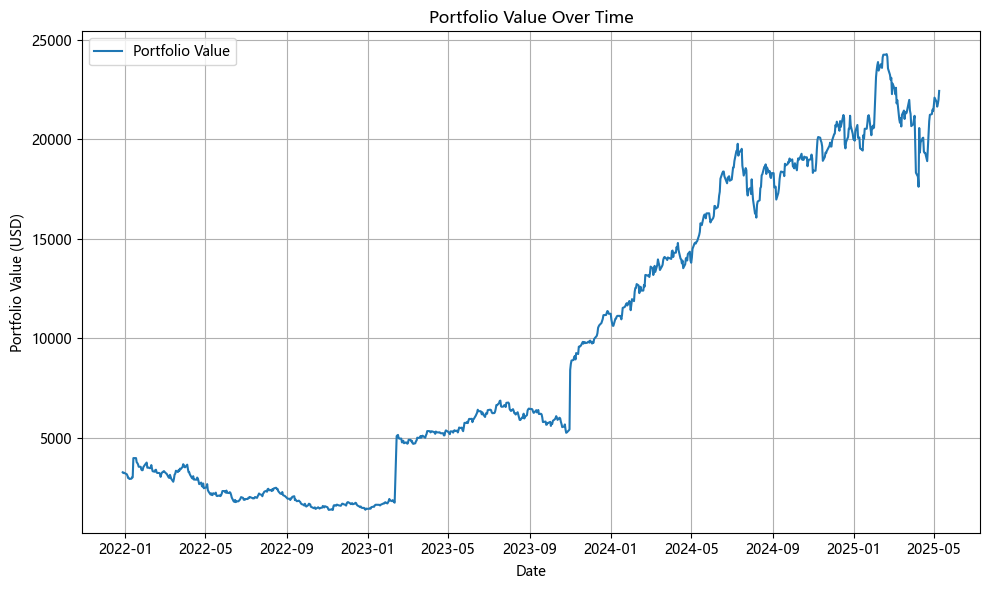

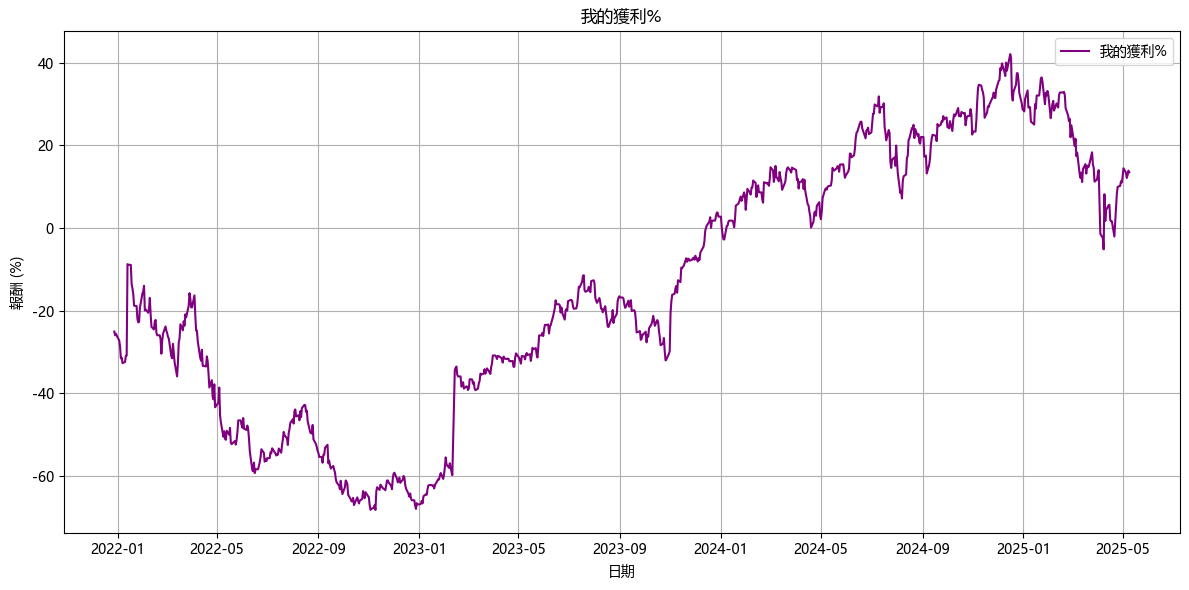

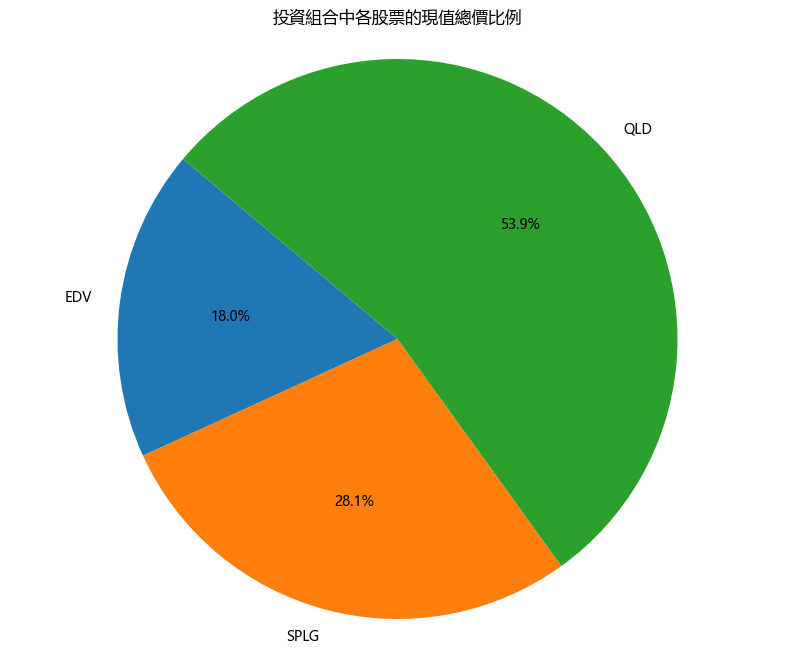

2023/2/10 到 2023/2/15 的市值:
2023-02-10    1749.011536
2023-02-13    5092.929684
2023-02-14    5127.752144
2023-02-15    5152.658781
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    1749.011536
2023-02-11    1749.011536
2023-02-12    1749.011536
2023-02-13    5092.929684
2023-02-14    5127.752144
2023-02-15    5152.658781
Freq: D, dtype: float64


In [9]:
%run us.py

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed



=== 綜合資產配置報告 (單位: USD) ===
累積買入金額：62,154.27 USD
實際淨投入資金：33,865.88 USD
最終組合市值：42,027.89 USD
總獲利：8,162.01 USD
總獲利百分比：24.10%
Sortino Ratio：7.09
Calmar Ratio：0.06
綜合 XIRR: 10.76%

=== 綜合資產配置報告 (單位: TWD) ===
累積買入金額：1,876,561.60 TWD
實際淨投入資金：1,022,478.59 TWD
最終組合市值：1,268,906.02 TWD
總獲利：246,427.44 TWD
總獲利百分比：24.10%
綜合 XIRR: 10.76%

=== 綜合投資組合股票明細 (TWD) ===
+----------+------------+----------------+----------+-----------+---------------+-----------+-------------+-------------+-----------+
| Symbol   | Name       |   Quantity_now |    Price | AvgCost   |   Price_Total |      Cost | Gain(USD)   | Gain(TWD)   | Gain(%)   |
|----------+------------+----------------+----------+-----------+---------------+-----------+-------------+-------------+-----------|
| 0050     | 0050       |              0 |  0       |           |         0     |   701.742 | 11.56       | 349.00      | 1.65%     |
| 2330     | 台積       |              0 |  0       |           |         0     |  1320.75  | 99.50       | 3,004.

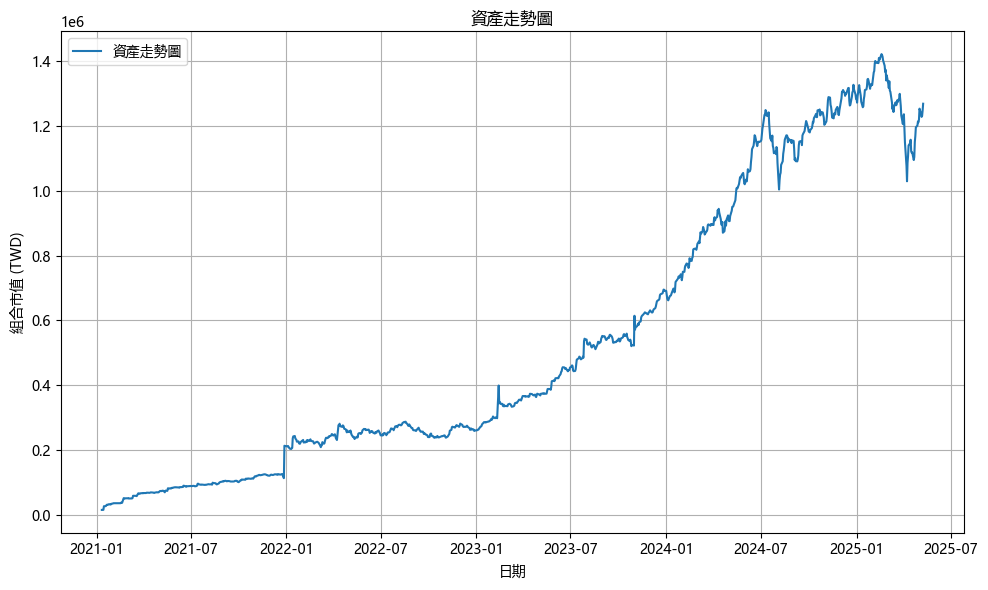

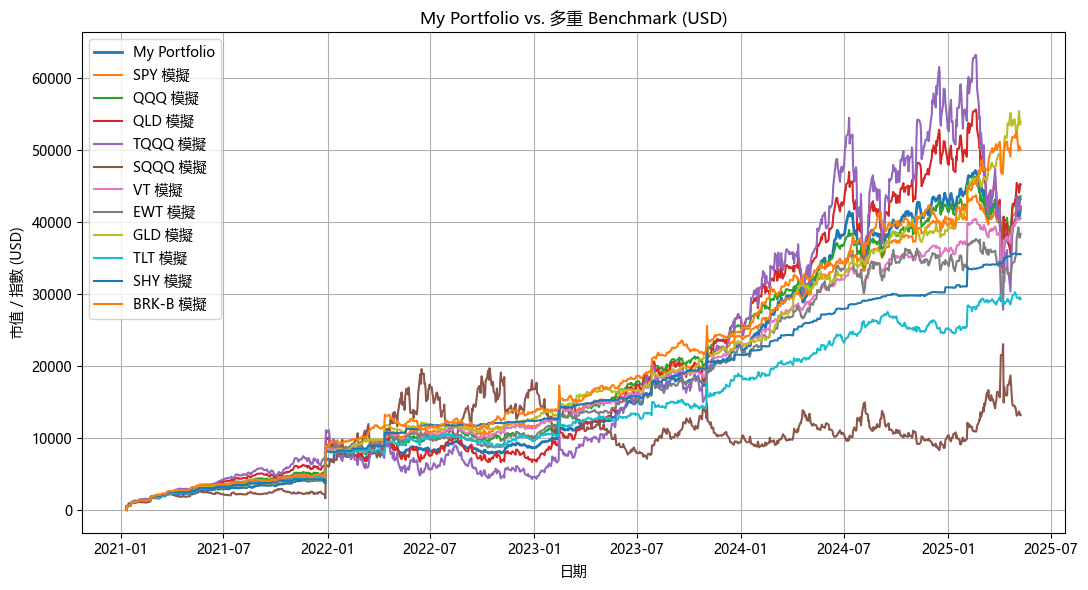

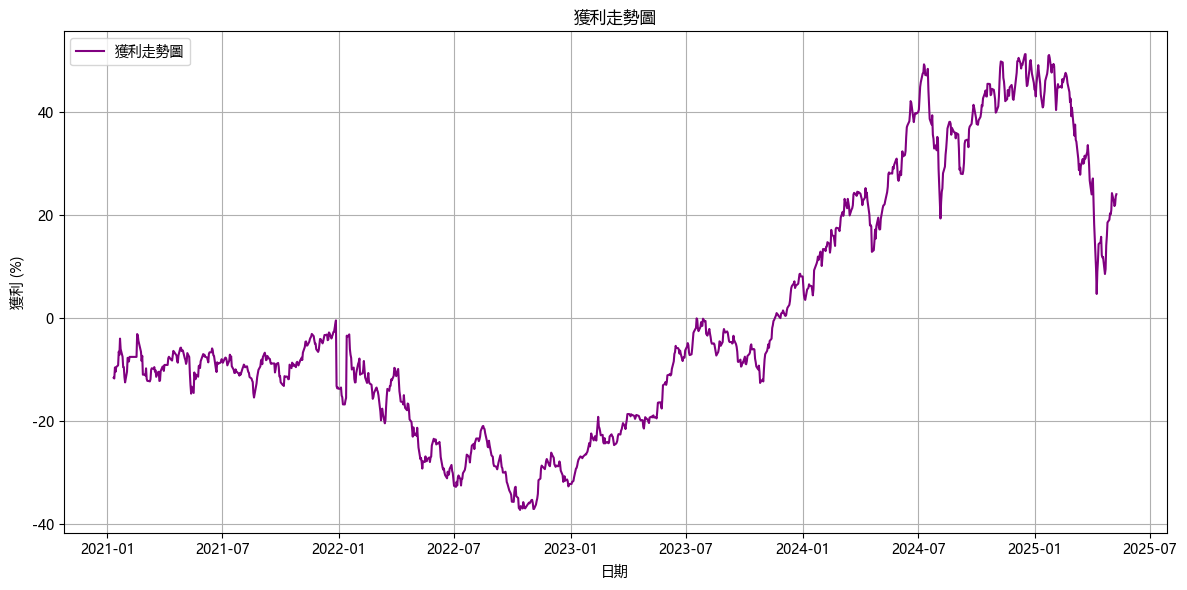

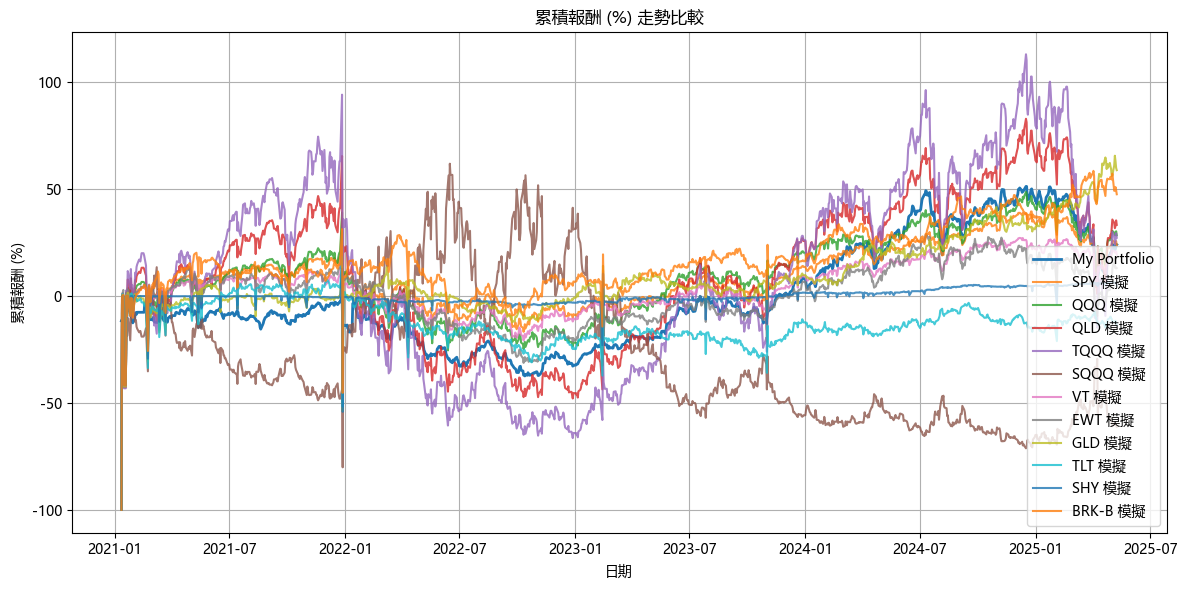

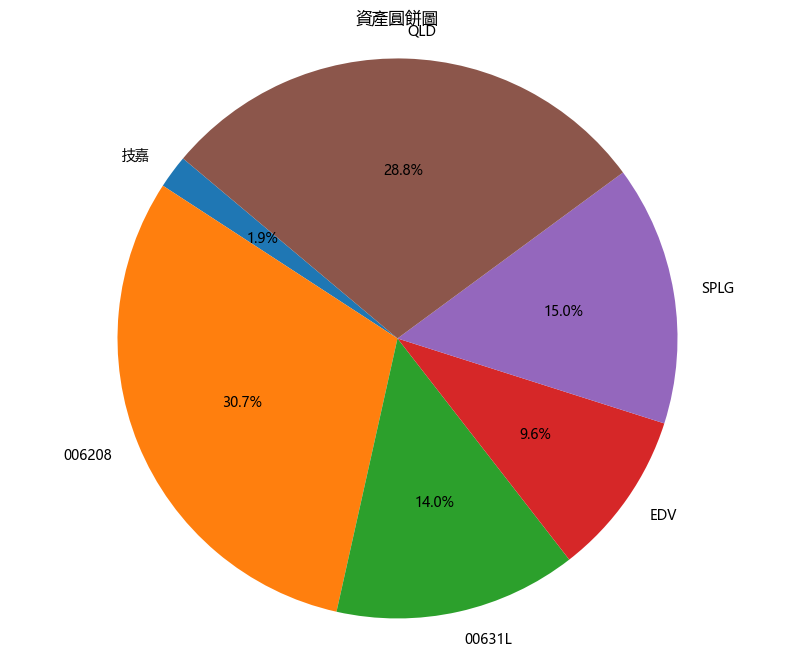

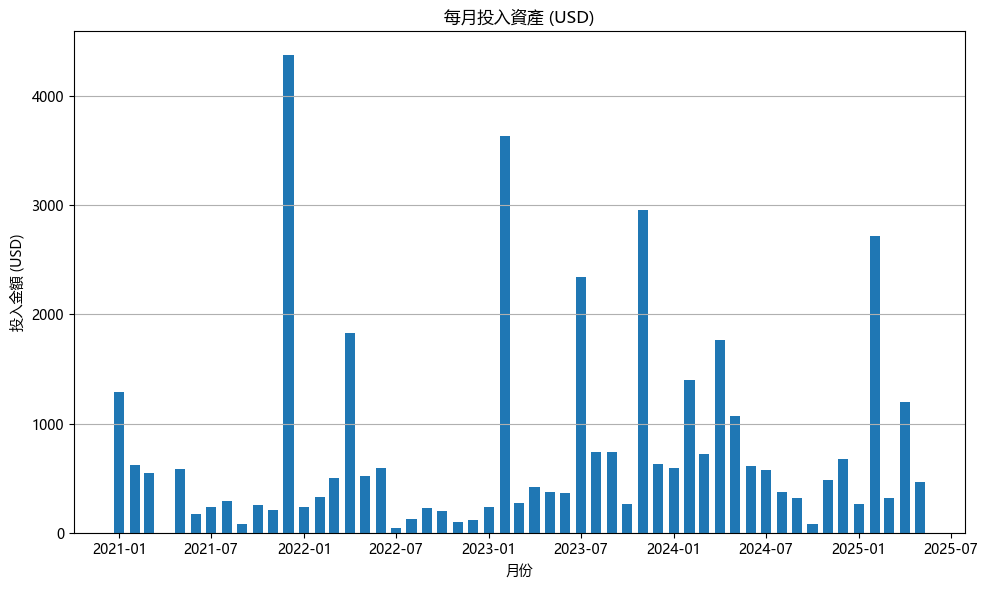

$00631L: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


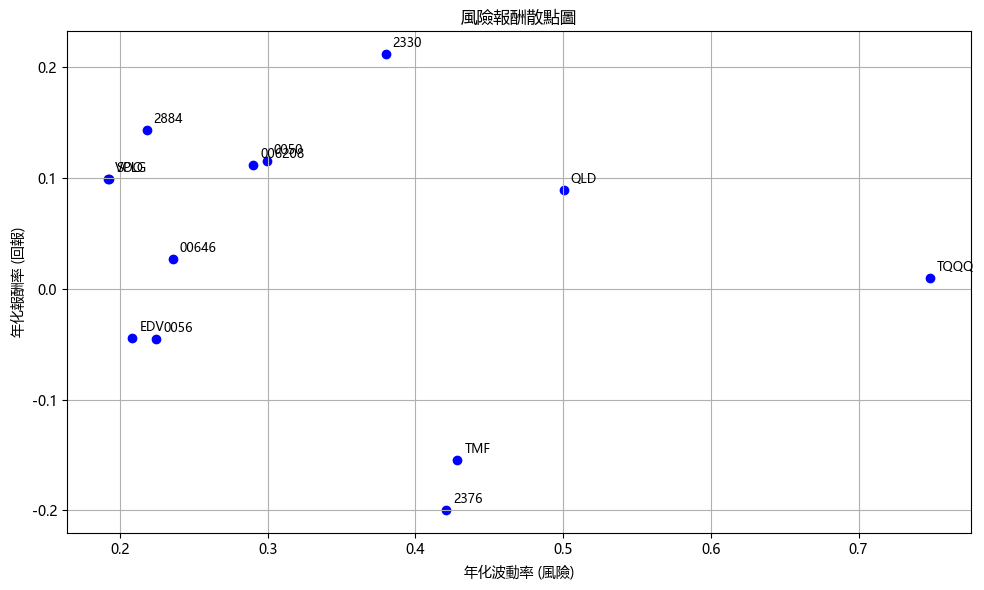

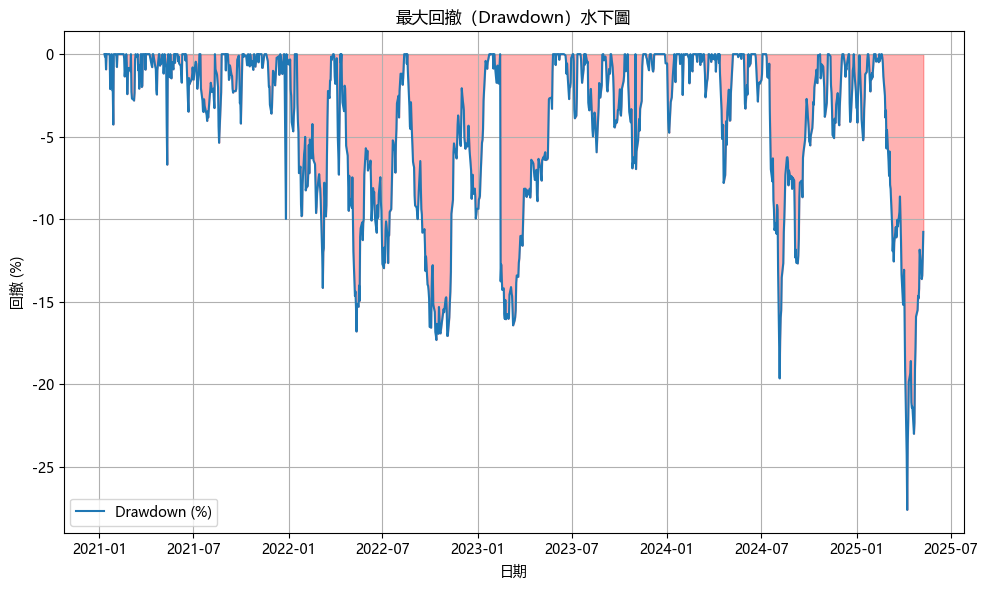


=== 投組 vs. Benchmark 總表 (TWD) ===
+--------------+---------------------+----------------+------------+----------+------------+-----------+
| Asset        |   Final Value (TWD) |   Profit (TWD) |   Profit % |   XIRR % |   AnnVol % |   MaxDD % |
|--------------+---------------------+----------------+------------+----------+------------+-----------|
| My Portfolio |          1268906.02 |      246427.44 |      24.10 |    10.76 |      66.46 |     27.60 |
| SPY          |          1266407.84 |      243929.26 |      23.86 |    10.66 |      67.14 |     17.31 |
| QQQ          |          1313841.52 |      291362.93 |      28.50 |    12.52 |      68.99 |     21.42 |
| QLD          |          1363492.19 |      341013.60 |      33.35 |    14.40 |      77.72 |     40.75 |
| TQQQ         |          1301953.62 |      279475.04 |      27.33 |    12.06 |      93.47 |     61.31 |
| SQQQ         |           397447.16 |     -625031.42 |     -61.13 |   nan    |     153.23 |     63.87 |
| VT           |    

C:\Git\TW_ETF\combine.py:69: RuntimeWarning: overflow encountered in scalar power
  return sum(cf / ((1 + rate) ** ((date - t0).days / 365.0))


In [17]:
%run combine.py